# IMPORTING IMPORTANT LIBRARIES

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from sklearn import preprocessing

In [5]:
# FOR REPRODUCIBILITY
np.random.seed(7)

# IMPORTING DATASET

In [6]:
dataset = pd.read_csv('/content/AAPL.csv', usecols=[1,2,3,4])
dataset = dataset.reindex(index = dataset.index[::-1])

In [7]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION

In [8]:
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]
OHLC_avg

1510    178.037499
1509    179.082500
1508    179.370003
1507    179.827499
1506    178.727501
           ...    
4        24.461250
3        24.480625
2        25.218750
1        26.045000
0        25.958125
Length: 1511, dtype: float64

# PLOTTING ALL INDICATORS IN ONE PLOT

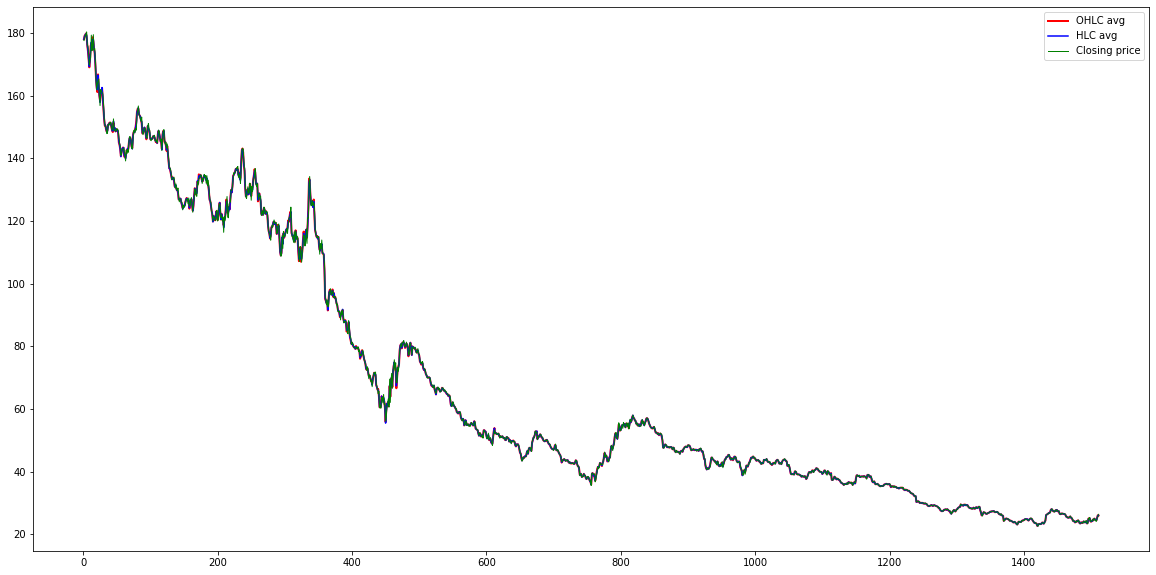

In [9]:
plt.figure(figsize=(20,10))
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg',linewidth=2)
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg',linewidth=1.5)
plt.plot(obs, close_val, 'g', label = 'Closing price',linewidth=1)
plt.legend(loc = 'upper right')
plt.show()

In [10]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

# TRAIN-TEST SPLIT

In [11]:
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [12]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
	  data_X, data_Y = [], []
	  for i in range(len(dataset)-step_size-1):
		    a = dataset[i:(i+step_size), 0]
		    data_X.append(a)
		    data_Y.append(dataset[i + step_size, 0])
	  return np.array(data_X), np.array(data_Y)

# THIS FUNCTION CAN BE USED TO CREATE A TIME SERIES DATASET FROM ANY 1D ARRAY

In [13]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [14]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

# LSTM MODEL

In [15]:
# Initialising the RNN
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (1, step_size)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

In [16]:
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy']) # Try SGD, adam, adagrad and compare!!!
history=model.fit(trainX, trainY, epochs=100, validation_data=(testX, testY), batch_size=1, verbose=1)
print(model.evaluate(testX,testY))  
# loss: 2.5194e-04 - accuracy: 0.0027

Epoch 1/100
1131/1131 [==============================] - 16s 8ms/step - loss: 0.0176 - accuracy: 8.8417e-04 - val_loss: 0.0013 - val_accuracy: 0.0027
Epoch 2/100
1131/1131 [==============================] - 8s 7ms/step - loss: 0.0038 - accuracy: 8.8417e-04 - val_loss: 3.6121e-05 - val_accuracy: 0.0027
Epoch 3/100
1131/1131 [==============================] - 7s 6ms/step - loss: 0.0024 - accuracy: 8.8417e-04 - val_loss: 8.2383e-04 - val_accuracy: 0.0027
Epoch 4/100
1131/1131 [==============================] - 6s 6ms/step - loss: 0.0025 - accuracy: 8.8417e-04 - val_loss: 5.1685e-04 - val_accuracy: 0.0027
Epoch 5/100
1131/1131 [==============================] - 6s 6ms/step - loss: 0.0018 - accuracy: 8.8417e-04 - val_loss: 0.0011 - val_accuracy: 0.0027
Epoch 6/100
1131/1131 [==============================] - 6s 6ms/step - loss: 0.0018 - accuracy: 8.8417e-04 - val_loss: 0.0028 - val_accuracy: 0.0027
Epoch 7/100
1131/1131 [==============================] - 6s 6ms/step - loss: 0.0019 - accurac

In [17]:
_, acc = model.evaluate(testX, testY, verbose=1)
print('> %.3f'%(acc*100.0))

12/12 [==============================] - 0s 3ms/step - loss: 1.9117e-04 - accuracy: 0.0027
> 0.266


In [32]:
# plot diagnostic learning curves
# plot loss
import sys
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
# save plot to file
filename = sys.argv[0].split('/')[-1]
plt.savefig(filename + '_plot.png')
plt.close()

# PREDICTION and PLOT

In [22]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [23]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [24]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 2.22


In [25]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 2.17


In [26]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [27]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

In [28]:
# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

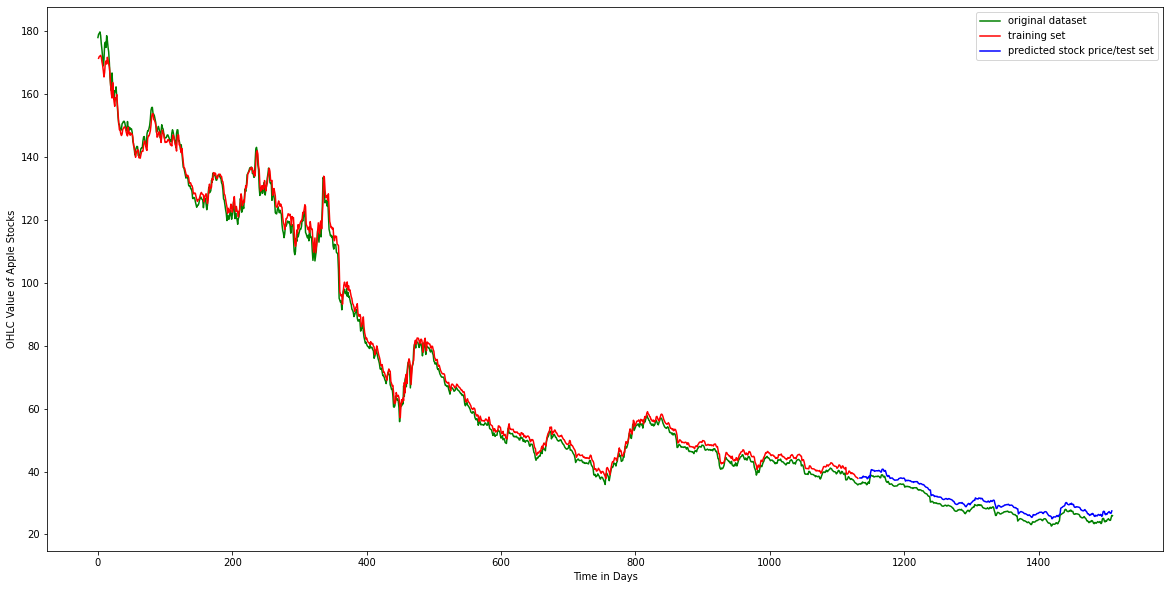

In [29]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.figure(figsize=(20,10))
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

In [30]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)

Last Day Value: 27.462984085083008
Next Day Value: 26.161317825317383


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
